Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Lastly, hit **Validate**.

If you worked locally, and then uploaded your work to the hub, make sure to follow these steps:
- open your uploaded notebook **on the hub**
- hit the validate button right above this cell, from inside the notebook

These  steps should solve any issue related to submitting the notebook on the hub.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Gilbert Antonius"
COLLABORATORS = ""

---

# Project 1: Trump, Twitter, and Text

Welcome to the first project of Data 100! In this project, we will work with the Twitter API in order to analyze Donald Trump's tweets.

**The project is due 11:59pm Tuesday, Feb 27, California Time.**

*Fair warning:* This project involves significantly more challenging pandas operations than the previous homeworks. We strongly suggest you start early.

**Fun:**

We intended this project to be fun! You will analyze actual data from the Twitter API. You will also draw conclusions about the current (and often controversial) US President's tweet behavior. If you find yourself getting frustrated or stuck on one problem for too long, we suggest coming into office hours and working with friends in the class.

*If you find yourself getting frustrated with the data we suggest you vote and/or encourage others to vote.*

With that in mind, let's get started!

In [2]:
# Run this cell to set up your notebook
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

# Downloading Recent Tweets

---

Since we'll be looking at Twitter data, we need to download the data from Twitter!

Twitter provides an API for downloading tweet data in large batches.  The `tweepy` package makes it fairly easy to use.

In [3]:
## Make sure you are in your data100 conda environment if you are working locally.
# The following should run:
import tweepy

There are instructions on using `tweepy` [here](http://tweepy.readthedocs.io/en/v3.5.0/getting_started.html), but we will give you example code.

Twitter requires you to have authentication keys to access their API.  To get your keys, you'll have to sign up as a Twitter developer.  The next question will walk you through this process.

## Question 1

Follow the instructions below to get your Twitter API keys.  **Read the instructions completely before starting.**

1. [Create a Twitter account](https://twitter.com).  You can use an existing account if you have one; if you prefer to not do this assignment under your regular account, feel free to create a throw-away account.
2. Under account settings, add your phone number to the account.
3. [Create a Twitter developer account](https://dev.twitter.com/resources/signup).  Attach it to your Twitter account.
4. Once you're logged into your developer account, [create an application for this assignment](https://apps.twitter.com/app/new).  You can call it whatever you want, and you can write any URL when it asks for a web site.  You don't need to provide a callback URL.
5. On the page for that application, find your Consumer Key and Consumer Secret.
6. On the same page, create an Access Token.  Record the resulting Access Token and Access Token Secret.
7. Edit the file [keys.json](keys.json) and replace the placeholders with your keys.  


## WARNING (Please Read) !!!!


### Protect your Twitter Keys
<span style="color:red">
If someone has your authentication keys, they can access your Twitter account and post as you!  So don't give them to anyone, and **don't write them down in this notebook**. 
</span>
The usual way to store sensitive information like this is to put it in a separate file and read it programmatically.  That way, you can share the rest of your code without sharing your keys.  That's why we're asking you to put your keys in `keys.json` for this assignment.


### Avoid making too many API calls.

<span style="color:red">
Twitter limits developers to a certain rate of requests for data.  If you make too many requests in a short period of time, you'll have to wait awhile (around 15 minutes) before you can make more.  </span> 
So carefully follow the code examples you see and don't rerun cells without thinking.  Instead, always save the data you've collected to a file.  We've provided templates to help you do that.


### Be careful about which functions you call!

<span style="color:red">
This API can retweet tweets, follow and unfollow people, and modify your twitter settings.  Be careful which functions you invoke! </span> One of your instructors accidentally re-tweeted some tweets because that instructor typed `retweet` instead of `retweet_count`. 
</span>


In [4]:
import json
key_file = 'keys.json'
# Loading your keys from keys.json (which you should have filled
# in in question 1):
with open(key_file) as f:
    keys = json.load(f)
# if you print or view the contents of keys be sure to delete the cell!

This cell tests the Twitter authentication. It should run without errors or warnings and display your Twitter username.

In [5]:
import tweepy
from tweepy import TweepError
import logging

try:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.")
    logging.warning(e)

Your username is: gilbertichwan


## Question 2

In the example below, we have loaded some tweets by @BerkeleyData.  Run it and read the code.

In [6]:
from pathlib import Path
import json

ds_tweets_save_path = "BerkeleyData_recent_tweets.json"
# Guarding against attempts to download the data multiple
# times:
if not Path(ds_tweets_save_path).is_file():
    # Getting as many recent tweets by @BerkeleyData as Twitter will let us have.
    # We use tweet_mode='extended' so that Twitter gives us full 280 character tweets.
    # This was a change introduced in September 2017.
    
    # The tweepy Cursor API actually returns "sophisticated" Status objects but we 
    # will use the basic Python dictionaries stored in the _json field. 
    example_tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id="BerkeleyData", 
                                             tweet_mode='extended').items()]
    
    # Saving the tweets to a json file on disk for future analysis
    with open(ds_tweets_save_path, "w") as f:        
        json.dump(example_tweets, f)

# Re-loading the json file:
with open(ds_tweets_save_path, "r") as f:
    example_tweets = json.load(f)

Assuming everything ran correctly you should be able to look at the first tweet by running the cell below.

<span style="color:red">
**Warning** Do not attempt to view all the tweets in a notebook.  It will likely freeze your browser.  The following would be a **bad idea**:
```python
    pprint(example_tweets)
```

</span> 

In [7]:
# Looking at one tweet object, which has type Status: 
from pprint import pprint # ...to get a more easily-readable view.
pprint(example_tweets[0])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Wed Feb 14 18:47:23 +0000 2018',
 'display_text_range': [0, 144],
 'entities': {'hashtags': [],
              'symbols': [],
              'urls': [],
              'user_mentions': [{'id': 263020833,
                                 'id_str': '263020833',
                                 'indices': [3, 19],
                                 'name': 'Berkeley School of Information',
                                 'screen_name': 'BerkeleyISchool'}]},
 'favorite_count': 0,
 'favorited': False,
 'full_text': 'RT @BerkeleyISchool: We LOVE the I School community! 💓💖💗 Our '
              'students, alumni, faculty &amp; staff make the I School a '
              'incredible place to lear…',
 'geo': None,
 'id': 963847153784369152,
 'id_str': '963847153784369152',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_

## Question 2a

### What you need to do. 

Re-factor the above code fragment into reusable snippets below.  You should not need to make major modifications; this is mostly an exercise in understanding the above code block. 

In [8]:
def load_keys(path):
    """Loads your Twitter authentication keys from a file on disk.
    
    Args:
        path (str): The path to your key file.  The file should
          be in JSON format and look like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }
    
    Returns:
        dict: A dictionary mapping key names (like "consumer_key") to
          key values."""
    import json
    with open(path) as f:
        auth_keys = json.load(f)
    return auth_keys

In [9]:
def download_recent_tweets_by_user(user_account_name, keys):
    """Downloads tweets by one Twitter user.

    Args:
        user_account_name (str): The name of the Twitter account
          whose tweets will be downloaded.
        keys (dict): A Python dictionary with Twitter authentication
          keys (strings), like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }

    Returns:
        list: A list of Dictonary objects, each representing one tweet."""
    import tweepy
    from tweepy import TweepError
    import logging

    try:
        auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
        auth.set_access_token(keys["access_token"], keys["access_token_secret"])
        api = tweepy.API(auth)
        print("Your username is:", user_account_name)
    except TweepError as e:
        logging.warning("There was a Tweepy error. Double check your API keys and try again.")
        logging.warning(e)   
        
    from pathlib import Path
    import json

    #ds_tweets_save_path = "BerkeleyData_recent_tweets.json"
    # Guarding against attempts to download the data multiple
    # times:
    #if not Path(ds_tweets_save_path).is_file():
        # Getting as many recent tweets by @BerkeleyData as Twitter will let us have.
        # We use tweet_mode='extended' so that Twitter gives us full 280 character tweets.
        # This was a change introduced in September 2017.
    
        # The tweepy Cursor API actually returns "sophisticated" Status objects but we 
        # will use the basic Python dictionaries stored in the _json field. 
    example_tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id=user_account_name, 
                                                     tweet_mode='extended').items()]
    return example_tweets
        

In [10]:
def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem.
    
    This function makes no guarantee about the format of the saved
    tweets, **except** that calling load_tweets(path) after
    save_tweets(tweets, path) will produce the same list of tweets
    and that only the file at the given path is used to store the
    tweets.  (That means you can implement this function however
    you want, as long as saving and loading works!)

    Args:
        tweets (list): A list of tweet objects (of type Dictionary) to
          be saved.
        path (str): The place where the tweets will be saved.
    Returns:
        None"""
    # Saving the tweets to a json file on disk for future analysis
    with open(path, "w") as f:        
        json.dump(tweets, f)

In [11]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets were be saved.

    Returns:
        list: A list of Dictionary objects, each representing one tweet."""
    
    # Re-loading the json file:
    with open(path, "r") as f:
        example_tweets = json.load(f)
    return example_tweets
    

In [12]:
def get_tweets_with_cache(user_account_name, keys_path):
    """Get recent tweets from one user, loading from a disk cache if available.
    
    The first time you call this function, it will download tweets by
    a user.  Subsequent calls will not re-download the tweets; instead
    they'll load the tweets from a save file in your local filesystem.
    All this is done using the functions you defined in the previous cell.
    This has benefits and drawbacks that often appear when you cache data:
    
    +: Using this function will prevent extraneous usage of the Twitter API.
    +: You will get your data much faster after the first time it's called.
    -: If you really want to re-download the tweets (say, to get newer ones,
       or because you screwed up something in the previous cell and your
       tweets aren't what you wanted), you'll have to find the save file
       (which will look like <something>_recent_tweets.pkl) and delete it.
    
    Args:
        user_account_name (str): The Twitter handle of a user, without the @.
        keys_path (str): The path to a JSON keys file in your filesystem.
    """
    
    tweets_save_path = user_account_name + "_recent_tweets.json"
    if not Path(tweets_save_path).is_file():
        save_tweets(download_recent_tweets_by_user(user_account_name, load_keys(keys_path)), tweets_save_path)
    return load_tweets(tweets_save_path)
    
    
    

If everything was implemented correctly you should be able to obtain roughly the last 3000 tweets by the `realdonaldtrump`.  (This may take a few minutes)

In [13]:
# When you are done, run this cell to load @realdonaldtrump's tweets.
# Note the function get_tweets_with_cache.  You may find it useful
# later.
trump_tweets = get_tweets_with_cache("realdonaldtrump", key_file)
print("Number of tweets downloaded:", len(trump_tweets))

Number of tweets downloaded: 3217


In [14]:
assert 2000 <= len(trump_tweets) <= 4000

### Question 2b

We are limited to how many tweets we can download.  In what month is the oldest tweet from Trump?

In [15]:
import re
import datetime

# Enter the number of the month of the oldest tweet (e.g. 1 for January)
temp = trump_tweets
oldest_month = temp[-1]['created_at']
oldest_month = pd.to_datetime(oldest_month)
oldest_month = oldest_month.month
oldest_month

10


## Question 3


**IMPORTANT! PLEASE READ**

Unfortunately, Twitter prevent us from going further back in time using the public APIs.  Fortunately, we have a snapshot of earlier tweets that we can combine with our new data.  

We will again use the `fetch_and_cache` utility to download the dataset. 

In [16]:
# Download the dataset
from utils import fetch_and_cache
data_url = 'http://www.ds100.org/sp18/assets/datasets/old_trump_tweets.json.zip'
file_name = 'old_trump_tweets.json.zip'

dest_path = fetch_and_cache(data_url=data_url, file=file_name)
print(f'Located at {dest_path}')

Using version already downloaded: Tue Feb 20 04:12:59 2018
MD5 hash of file: d9419cad17e76c87fe646b587f6e8ca5
Located at data/old_trump_tweets.json.zip


Finally, we we will load the tweets directly from the compressed file without decompressing it first.

In [17]:
my_zip = zipfile.ZipFile(dest_path, 'r')
with my_zip.open("old_trump_tweets.json", "r") as f:
    old_trump_tweets = json.load(f)

This data is formatted identically to the recent tweets we just downloaded:

In [18]:
pprint(old_trump_tweets[0])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Wed Oct 12 14:00:48 +0000 2016',
 'entities': {'hashtags': [{'indices': [23, 38], 'text': 'CrookedHillary'}],
              'media': [{'display_url': 'pic.twitter.com/wjsl8ITVvk',
                         'expanded_url': 'https://twitter.com/realDonaldTrump/status/786204978629185536/video/1',
                         'id': 786204885318561792,
                         'id_str': '786204885318561792',
                         'indices': [39, 62],
                         'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/786204885318561792/pu/img/XqMoixLm83FzkAbn.jpg',
                         'media_url_https': 'https://pbs.twimg.com/ext_tw_video_thumb/786204885318561792/pu/img/XqMoixLm83FzkAbn.jpg',
                         'sizes': {'large': {'h': 576,
                                             'resize': 'fit',
                                             'w': 1024},
                                   'medium': {'h': 338

As a dictionary we can also list the keys:

In [19]:
old_trump_tweets[0].keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

### Question 3a

Merge the `old_trump_tweets` and the `trump_tweets` we downloaded from twitter into one giant list of tweets. 

**Important:** There may be some overlap so be sure to eliminate duplicate tweets.  
**Hint:** the `id` of a tweet is always unique.

In [20]:
all_tweets = old_trump_tweets[:]

i = 0
while (i < len(trump_tweets)):
    count = 0
    j = 0
    while (j < len(old_trump_tweets)):
        if (trump_tweets[i]['id'] != old_trump_tweets[j]['id']):
            count += 1
        if (count == len(old_trump_tweets)):
            all_tweets.append(trump_tweets[i])
        j += 1
    i += 1

In [21]:
assert len(all_tweets) > len(trump_tweets)
assert len(all_tweets) > len(old_trump_tweets)

### Question 3b

Construct a DataFrame called `trump` containing all the tweets stored in `all_tweets`. The index of the dataframe should be the ID of each tweet (looks something like `907698529606541312`). It should have these columns:

- `time`: The time the tweet was created encoded as a datetime object. (Use `pd.to_datetime` to encode the timestamp.)
- `source`: The source device of the tweet.
- `text`: The text of the tweet.
- `retweet_count`: The retweet count of the tweet. 

Finally, **the resulting dataframe should be sorted by the index.**

**Warning:** *Some tweets will store the text in the `text` field and other will use the `full_text` field.*

In [22]:

trump = pd.DataFrame(all_tweets)[['created_at', 'source', 'text', 'full_text', 'retweet_count', 'id']]
trump['created_at'] = pd.to_datetime(trump['created_at'])
trump = trump.sort_values("id", ascending=True)
trump = trump.set_index('id')
trump.rename(columns={'created_at': 'time'}, inplace=True)
#trump['text'].fillna(trump['full_text'])
trump['text'].fillna(trump['full_text'], inplace=True)
trump = trump.drop('full_text', 1)


In [23]:
assert isinstance(trump, pd.DataFrame)
assert trump.shape[0] < 8000
assert trump.shape[1] >= 4
assert 831846101179314177 in trump.index
assert 753063644578144260 in trump.index
assert all(col in trump.columns for col in ['time', 'source', 'text', 'retweet_count'])
# If you fail these tests, you probably tried to use __dict__ or _json to read in the tweets
assert np.sometrue([('Twitter for iPhone' in s) for s in trump['source'].unique()])
assert trump['time'].dtype == np.dtype('<M8[ns]')
assert trump['text'].dtype == np.dtype('O')
assert trump['retweet_count'].dtype == np.dtype('int64')

## Question 4: Tweet Source Analysis

In the following questions, we are going to find out the charateristics of Trump tweets and the devices used for the tweets.

First let's examine the source field:

In [24]:
trump['source'].unique()

array([ '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>',
       '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       '<a href="https://periscope.tv" rel="nofollow">Periscope</a>',
       '<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>'], dtype=object)

## Question 4a

Remove the HTML tags from the source field. 

**Hint:** Use `trump['source'].str.replace` and your favorite regular expression.

In [25]:
trump['source'] = trump['source'].str.replace("<[^>]*>", "")
trump['source']

id
690171032150237184    Twitter for Android
690171403388104704    Twitter for Android
690173226341691392    Twitter for Android
690176882055114758    Twitter for Android
690180284189310976    Twitter for Android
690271688127213568     Twitter for iPhone
690272687168458754    Twitter for Android
690313350278819840     Twitter for iPhone
690315202261155840     Twitter for iPhone
690315366564626433     Twitter for iPhone
690315667636023296     Twitter for iPhone
690336644281581568     Twitter for iPhone
690337376061788161     Twitter for iPhone
690382564494839809     Twitter for iPhone
690382619213742082     Twitter for iPhone
690382722162913280     Twitter for iPhone
690404308010057728     Twitter for iPhone
690528062190944256    Twitter for Android
690528407117889538    Twitter for Android
690528526181601281    Twitter for Android
690529122326413314    Twitter for Android
690529690205818880    Twitter for Android
690530164711624705    Twitter for Android
690532959363866625    Twitter f

In [26]:
from datetime import datetime
ELEC_DATE = datetime(2016, 11, 8)
INAUG_DATE = datetime(2017, 1, 20)
assert set(trump[(trump['time'] > ELEC_DATE) & (trump['time'] < INAUG_DATE) ]['source'].unique()) == set(['Twitter Ads',
 'Twitter Web Client',
 'Twitter for Android',
 'Twitter for iPhone'])

We can see in the following plot that there are two device types that are more commonly used

Text(0,0.5,'Number of Tweets')

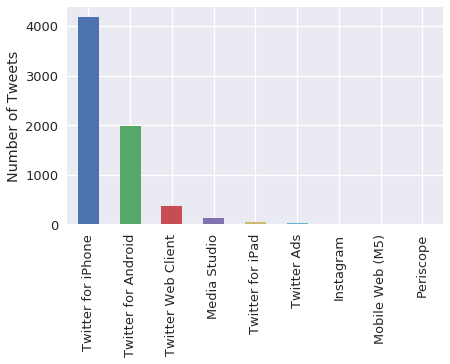

In [27]:
trump['source'].value_counts().plot(kind="bar")
plt.ylabel("Number of Tweets")

## Question 4b


Is there a difference between his Tweet behavior across these devices? We will attempt to answer this question in our subsequent analysis.

First, we'll take a look at whether Trump's tweets from an Android come at different times than his tweets from an iPhone. Note that Twitter gives us his tweets in the [UTC timezone](https://www.wikiwand.com/en/List_of_UTC_time_offsets) (notice the `+0000` in the first few tweets)

In [28]:
for t in trump_tweets[0:3]:
    print(t['created_at'])

Mon Feb 19 13:42:10 +0000 2018
Mon Feb 19 04:28:40 +0000 2018
Sun Feb 18 19:13:02 +0000 2018


We'll convert the tweet times to US Eastern Time, the timezone of New York and Washington D.C., since those are the places we would expect the most tweet activity from Trump.

In [29]:
trump['est_time'] = (
    trump['time'].dt.tz_localize("UTC") # Set initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
trump.head()

,time,source,text,retweet_count,est_time
id,,,,,
690171032150237184,2016-01-21 13:56:11,Twitter for Android,"""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059,2016-01-21 08:56:11-05:00
690171403388104704,2016-01-21 13:57:39,Twitter for Android,"""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339,2016-01-21 08:57:39-05:00
690173226341691392,2016-01-21 14:04:54,Twitter for Android,So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006,2016-01-21 09:04:54-05:00
690176882055114758,2016-01-21 14:19:26,Twitter for Android,"Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266,2016-01-21 09:19:26-05:00
690180284189310976,2016-01-21 14:32:57,Twitter for Android,Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886,2016-01-21 09:32:57-05:00


**What you need to do:**

Add a column called `hour` to the `trump` table which contains the hour of the day as floating point number computed by:

$$
\text{hour} + \frac{\text{minute}}{60} + \frac{\text{second}}{60^2}
$$


In [30]:
trump['hour'] = trump['est_time'].apply(lambda x: (x.hour + (x.minute / 60) + (x.second / (60**2))))


In [31]:
assert np.isclose(trump.loc[690171032150237184]['hour'], 8.93639)

## Question 4c

Use this data along with the seaborn `distplot` function to examine the distribution over hours of the day in `easter time` that trump tweets on each device for the 2 most commonly used devices.  Your plot should look similar to the following. 

<img src="images/device_hour2.png" width="600px" />

In [32]:
trump

,time,source,text,retweet_count,est_time,hour
id,,,,,,
690171032150237184,2016-01-21 13:56:11,Twitter for Android,"""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059,2016-01-21 08:56:11-05:00,8.936389
690171403388104704,2016-01-21 13:57:39,Twitter for Android,"""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339,2016-01-21 08:57:39-05:00,8.960833
690173226341691392,2016-01-21 14:04:54,Twitter for Android,So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006,2016-01-21 09:04:54-05:00,9.081667
690176882055114758,2016-01-21 14:19:26,Twitter for Android,"Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266,2016-01-21 09:19:26-05:00,9.323889
690180284189310976,2016-01-21 14:32:57,Twitter for Android,Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886,2016-01-21 09:32:57-05:00,9.549167
690271688127213568,2016-01-21 20:36:09,Twitter for iPhone,New Day on CNN treats me very badly. @AlisynCamerota is a disaster. Not going to watch anymore.,1429,2016-01-21 15:36:09-05:00,15.602500
690272687168458754,2016-01-21 20:40:07,Twitter for Android,"Happy birthday to my friend, the great @jacknicklaus - a totally special guy!",1053,2016-01-21 15:40:07-05:00,15.668611
690313350278819840,2016-01-21 23:21:42,Twitter for iPhone,"Thank you, Iowa! #Trump2016 https://t.co/ryhEheTLqN",2329,2016-01-21 18:21:42-05:00,18.361667
690315202261155840,2016-01-21 23:29:04,Twitter for iPhone,Thank you! #Trump2016 https://t.co/pcdmyIO1Zt,1463,2016-01-21 18:29:04-05:00,18.484444


Text(0,0.5,'fraction')

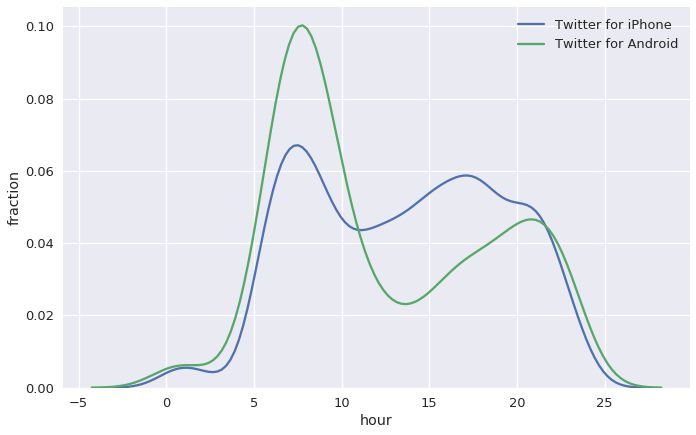

In [33]:
trump_android = trump[['source', 'hour']].loc[trump['source'] == 'Twitter for Android', :]
trump_android = trump_android['hour']
trump_iphone = trump[['source', 'hour']].loc[trump['source'] == 'Twitter for iPhone', :]
trump_iphone = trump_iphone['hour']


plt.figure(figsize=(10, 7))
sns.distplot(trump_iphone, hist=False, kde_kws={"label": "Twitter for iPhone"})
sns.distplot(trump_android, hist=False, kde_kws={"label": "Twitter for Android"})

plt.ylabel('fraction')





## Question 4d

Are there any striking differences between these curves.  If someone told you that Trump tends to tweet early in the morning and then later in the evening, which device might you conclude is most likely his?

The two curves are similar; they both have peaks at around the seventh and eight hours as well as another peak ar around 17th and 21st hours. If someone told me that Trump tends to tweet early in the morning and then later in the evening, I would tend to answer that the Android device might more strongly suppport this claim and it is Trump's device. But, the iPhone also have a similar pattern; thus, Trump might also use the iPhone.

## Question 5

Let's now look at which device he has used over the entire time period of this dataset.

To examine the distribution of dates we will convert the date to a fractional year that can be plotted as a distribution.

(Code borrowed from https://stackoverflow.com/questions/6451655/python-how-to-convert-datetime-dates-to-decimal-years)

In [34]:
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length


trump['year'] = trump['time'].apply(year_fraction)

### Question 5a

Use the `sns.distplot` to overlay the distributions of the 2 most frequently used web technologies over the years.  Your final plot should look like:

<img src="images/source_years.png" width="600px" />


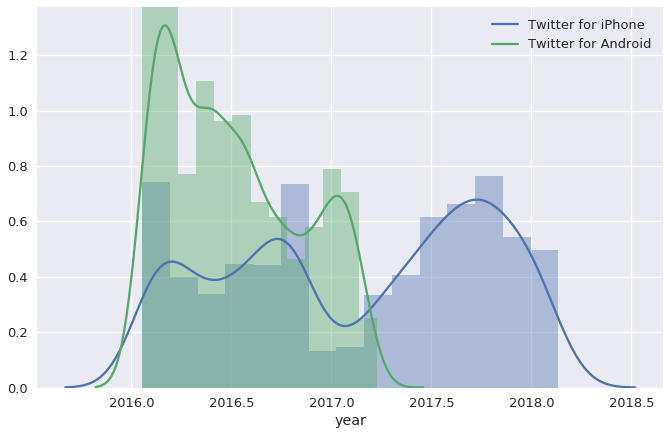

In [35]:
trump_android_yr = trump.loc[trump['source'] == 'Twitter for Android', :]
trump_android_yr = trump_android_yr['year']

trump_iphone_yr = trump.loc[trump['source'] == 'Twitter for iPhone', :]
trump_iphone_yr = trump_iphone_yr['year']

plt.figure(figsize=(10, 7))
sns.distplot(trump_iphone_yr, kde_kws={"label": "Twitter for iPhone"})
sns.distplot(trump_android_yr, kde_kws={"label": "Twitter for Android"})



### Question 5b
According to the plot, Trump's tweets come from many different sources. It turns out that many of his tweets were not from Trump himself but from his staff. [Take a look at this Verge article.](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android)

Does the data support the information in the article? What else do you find out about changes in Trump's tweets sources from the plot?

The data supports the information in the article since the graph shows that the Tweets sent after his inauguration on January 2017 are sent from the iPhone instead of Android. Another thing that can be observed is that there are tweets sent from Trump's account that are sent from the iPhone before the inauguration. This means that Trump might use two devices (iPhone and Android) to tweet or the iPhone tweets are not made by Trump himself, but by someone else on his behalf.

## Question 6: Sentiment Analysis

It turns out that we can use the words in Trump's tweets to calculate a measure of the sentiment of the tweet. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Trump's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [36]:
print(''.join(open("vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



## Question 6a

As you can see, the lexicon contains emojis too! The first column of the lexicon is the *token*, or the word itself. The second column is the *polarity* of the word, or how positive / negative it is.

(How did they decide the polarities of these words? What are the other two columns in the lexicon? See the link above.)

 Read in the lexicon into a DataFrame called `sent`. The index of the DF should be the tokens in the lexicon. `sent` should have one column: `polarity`: The polarity of each token.

In [37]:
open("vader_lexicon.txt").readlines()[:10]

['$:\t-1.5\t0.80623\t[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]\n',
 '%)\t-0.4\t1.0198\t[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]\n',
 '%-)\t-1.5\t1.43178\t[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]\n',
 '&-:\t-0.4\t1.42829\t[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]\n',
 '&:\t-0.7\t0.64031\t[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]\n',
 "( '}{' )\t1.6\t0.66332\t[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]\n",
 '(%\t-0.9\t0.9434\t[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]\n',
 "('-:\t2.2\t1.16619\t[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]\n",
 "(':\t2.3\t0.9\t[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]\n",
 '((-:\t2.1\t0.53852\t[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]\n']

In [38]:
sent = pd.read_table("vader_lexicon.txt", header=None, usecols=[0,1])
#sent.reindex(sent[0])

sent.rename({0: 'index', 1: 'polarity'}, axis='columns', inplace=True)
sent.set_index(sent['index'], inplace=True)
sent.drop('index', axis=1, inplace=True)


In [39]:
assert isinstance(sent, pd.DataFrame)
assert sent.shape == (7517, 1)
assert list(sent.index[5000:5005]) == ['paranoids', 'pardon', 'pardoned', 'pardoning', 'pardons']
assert np.allclose(sent['polarity'].head(), [-1.5, -0.4, -1.5, -0.4, -0.7])

## Question 6b

Now, let's use this lexicon to calculate the overall sentiment for each of Trump's tweets. Here's the basic idea:

1. For each tweet, find the sentiment of each word.
2. Calculate the sentiment of each tweet by taking the sum of the sentiments of its words.

First, let's lowercase the text in the tweets since the lexicon is also lowercase. Set the `text` column of the `trump` DF to be the lowercased text of each tweet.

In [40]:
trump['text'] = trump['text'].apply(str.lower)

In [41]:
assert trump['text'].loc[884740553040175104] == 'working hard to get the olympics for the united states (l.a.). stay tuned!'

## Question 6c

Now, let's get rid of punctuation since it'll cause us to fail to match words. Create a new column called `no_punc` in the `trump` DF to be the lowercased text of each tweet with all punctuation replaced by a single space. We consider punctuation characters to be any character that isn't a Unicode word character or a whitespace character. You may want to consult the Python documentation on regexes for this problem.

(Why don't we simply remove punctuation instead of replacing with a space? See if you can figure this out by looking at the tweet data.)

In [42]:
# Save your regex in punct_re
punct_re = r'[^\w\s]'
trump['no_punc'] = trump['text'].str.replace(punct_re, ' ')


In [43]:
assert isinstance(punct_re, str)
assert re.search(punct_re, 'this') is None
assert re.search(punct_re, 'this is ok') is None
assert re.search(punct_re, 'this is\nok') is None
assert re.search(punct_re, 'this is not ok.') is not None
assert re.search(punct_re, 'this#is#ok') is not None
assert re.search(punct_re, 'this^is ok') is not None
assert trump['no_punc'].loc[800329364986626048] == 'i watched parts of  nbcsnl saturday night live last night  it is a totally one sided  biased show   nothing funny at all  equal time for us '
assert trump['no_punc'].loc[894620077634592769] == 'on  purpleheartday i thank all the brave men and women who have sacrificed in battle for this great nation   usa   https   t co qmfdlslp6p'
# If you fail these tests, you accidentally changed the text column
assert trump['text'].loc[884740553040175104] == 'working hard to get the olympics for the united states (l.a.). stay tuned!'

## Question 6d:


Now, let's convert the tweets into what's called a [*tidy format*](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) to make the sentiments easier to calculate. Use the `no_punc` column of `trump` to create a table called `tidy_format`. The index of the table should be the IDs of the tweets, repeated once for every word in the tweet. It has two columns:

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.

The first few rows of our `tidy_format` table look like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>num</th>
      <th>word</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>894661651760377856</th>
      <td>0</td>
      <td>i</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>1</td>
      <td>think</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>2</td>
      <td>senator</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>3</td>
      <td>blumenthal</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>4</td>
      <td>should</td>
    </tr>
  </tbody>
</table>

**Note that you'll get different results depending on when you pulled in the tweets.** However, you can double check that your tweet with ID `894661651760377856` has the same rows as ours. Our tests don't check whether your table looks exactly like ours.

This will require some rather advanced Pandas hacking, but our solution uses a chain of 5 methods on the `trump` DF.

* **Hint 1:** Try looking at the `expand` argument to pandas' `str.split`.

* **Hint 2:** Try looking at the `stack()` method.


In [44]:
tidy_format = trump.loc[:, ['no_punc']]
tidy_format = tidy_format['no_punc'].str.split(expand=True)
tidy_format = tidy_format.stack().to_frame()
tidy_format = tidy_format.reset_index()
tidy_format = tidy_format.rename({'level_1': 'num', 0: 'word'}, axis='columns')
tidy_format.set_index(['id'], inplace=True)

tidy_format


,num,word
id,,
690171032150237184,0,bigop1
690171032150237184,1,realdonaldtrump
690171032150237184,2,sarahpalinusa
690171032150237184,3,https
690171032150237184,4,t
690171032150237184,5,co
690171032150237184,6,3kyqgqevyd
690171403388104704,0,americanaspie
690171403388104704,1,glennbeck


In [45]:
assert tidy_format.loc[894661651760377856].shape == (27, 2)
assert ' '.join(list(tidy_format.loc[894661651760377856]['word'])) == 'i think senator blumenthal should take a nice long vacation in vietnam where he lied about his service so he can at least say he was there'

## Question 6e:

Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each tweet: we can join the table with the lexicon table. 

Add a `polarity` column to the `trump` table.  The `polarity` column should contain the sum of the sentiment polarity of each word in the text of the tweet.

**Hint** you will need to merge the `tidy_format` and `sent` tables and group the final answer.


In [46]:
temp = tidy_format.join(sent, 'word')
temp = temp.groupby(temp.index.values).agg(np.nansum)
temp = temp.loc[:, ['polarity']]
trump['polarity'] = temp

In [47]:
assert np.allclose(trump.loc[744701872456536064, 'polarity'], 8.4)
assert np.allclose(trump.loc[745304731346702336, 'polarity'], 2.5)
assert np.allclose(trump.loc[744519497764184064, 'polarity'], 1.7)
assert np.allclose(trump.loc[894661651760377856, 'polarity'], 0.2)
assert np.allclose(trump.loc[894620077634592769, 'polarity'], 5.4)
# If you fail this test, you dropped tweets with 0 polarity
assert np.allclose(trump.loc[744355251365511169, 'polarity'], 0.0)

Now we have a measure of the sentiment of each of his tweets! Note that this calculation is rather basic; you can read over the VADER readme to understand a more robust sentiment analysis.

Now, run the cells below to see the most positive and most negative tweets from Trump in your dataset:

In [48]:
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   horrible and cowardly terrorist attack on innocent and defenseless worshipers in egypt. the world cannot tolerate terrorism, we must defeat them militarily and discredit the extremist ideology that forms the basis of their existence!

   democrat jon ossoff would be a disaster in congress. very weak on crime and illegal immigration, bad for jobs and wants higher taxes. say no

   "@fiiibuster: @jeffzeleny pathetic - you have no sufficient evidence that donald trump did not suffer from voter fraud, shame! bad reporter.

   nyc terrorist was happy as he asked to hang isis flag in his hospital room. he killed 8 people, badly injured 12. should get death penalty!

   yet another terrorist attack today in israel -- a father, shot at by a palestinian terrorist, was killed while:
https://t.co/cv1hzkvbit


In [49]:
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   thank you to linda bean of l.l.bean for your great support and courage. people will support you even more now. buy l.l.bean. @lbperfectmaine

   it was my great honor to celebrate the opening of two extraordinary museums-the mississippi state history museum &amp; the mississippi civil rights museum. we pay solemn tribute to our heroes of the past &amp; dedicate ourselves to building a future of freedom, equality, justice &amp; peace. https://t.co/5akgvpv8aa

   rt @ivankatrump: 2016 has been one of the most eventful and exciting years of my life. i wish you peace, joy, love and laughter. happy new…

   today, it was my great honor to sign a new executive order to ensure veterans have the resources they need as they transition back to civilian life. we must ensure that our heroes are given the care and support they so richly deserve! https://t.co/0mdp9ddias https://t.co/lp2a8kcbap

   it was my great honor to welcome mayor’s from across america to the wh. my ad

## Question 6g

Plot the distribution of tweet sentiments broken down by whether the text of the tweet contains `nyt` or `fox`.  Then in the box below comment on what we observe?

Text(0.5,0,'polarity')

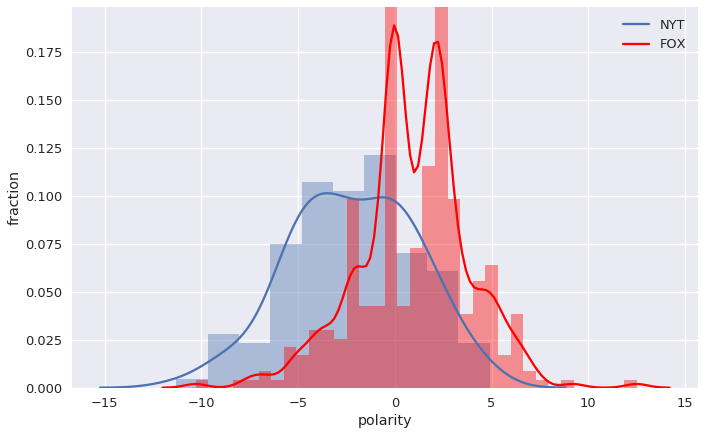

In [50]:
lst_nyt = []
lst_fox = []

for i in trump.index.values:
    if 'nyt' in trump['text'][i]:
        lst_nyt.append(trump['polarity'][i])
    if 'fox' in trump['text'][i]:
        lst_fox.append(trump['polarity'][i])
        
plt.figure(figsize=(10, 7))
sns.distplot(lst_nyt, kde_kws={"label": "NYT"})
sns.distplot(lst_fox, color='r', kde_kws={"label": "FOX"})

plt.ylabel('fraction')
plt.xlabel('polarity')
        

#### Comment on what you observe:

It can be seen that the distribution of tweets containing the word "nyt" centers on the negative value while the distribution of tweets containing the word "fox" centers at around 0 and 2.5 on the polarity scale. These two curves represent Trump's sentiment toward each of the two media companies; Trump favors Fox more than NYT, he even dislikes the NYT.

## Question 7: Engagement

## Question 7a

Which of Trump's tweets had the most retweets? Were there certain words that often led to more retweets?

We can find this out by using our `tidy_format` DataFrame. For each word in the `tidy_format` DF, find out the number of retweets that its tweet got. Filter out words that didn't appear in at least 25 tweets, find out the median number of retweets each word got, and save the top 20 most retweeted words into a DataFrame called `top_20`. Your `top_20` table should have this format:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>retweet_count</th>
    </tr>
    <tr>
      <th>word</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>fake</th>
      <td>22963.0</td>
    </tr>
    <tr>
      <th>news</th>
      <td>20463.0</td>
    </tr>
    <tr>
      <th>ds100</th>
      <td>20432.0</td>
    </tr>
    <tr>
      <th>great</th>
      <td>20159.0</td>
    </tr>
    <tr>
      <th>class</th>
      <td>20121.0</td>
    </tr>
  </tbody>
</table>

In [51]:
top_20 = trump.join(tidy_format).loc[:, ['word', 'retweet_count']]
top_20 = top_20.groupby('word').filter(lambda x: len(x) >= 25)
top_20 = top_20.groupby('word').agg(np.median).sort_values('retweet_count', ascending=False)
top_20 = top_20.iloc[0:20]

top_20


,retweet_count
word,
nfl,24748.0
daca,24495.0
anthem,24333.5
fbi,23975.0
russia,23922.0
fake,23530.0
finally,23468.0
schumer,22880.0
collusion,22748.0


In [52]:
#### NOTE This Test is kind of iffy (very variable) - needs review before publishing

# Although it can't be guaranteed, it's very likely that the top 7 words will still be
# in the top 20 words in the next month.
assert 'daca'     in top_20.index
assert 'nfl'     in top_20.index
assert 'anthem' in top_20.index
assert 'fbi'    in top_20.index
assert 'russia'    in top_20.index


Here's a bar chart of your results:

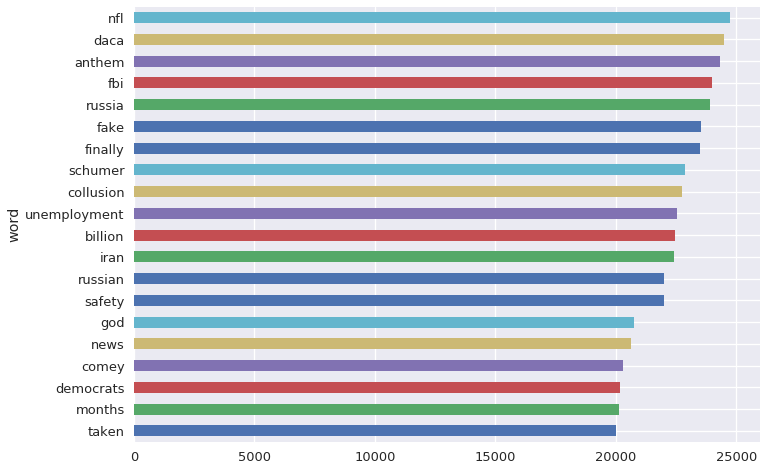

In [53]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8));

## Question 7b

The phrase "fake news" is apparently really popular! We can conclude that Trump's tweets containing "fake" and/or "news" result in the most retweets relative to words his other tweets. Or can we?

Consider each of the statements about possible confounding factors below. State whether each statement is true or false and explain. If the statement is true, state whether the confounding factor could have made "fake" and/or "news" higher on our list than they should be.

1. We didn't restrict our word list to nouns, so we have unhelpful words like "let" and "any" in our result.
1. We didn't remove hashtags in our text, so we have duplicate words (eg. #great and great).
1. We didn't account for the fact that Trump's follower count has increased over time.

1. True, unhelpful words can make into the top tweets. Based on the top_20 table, some of these unhelpful words include the word "finally" and "taken". The confounding factor would slightly change the position of "fake" and/or "news" on our list since there is only one unhelpful word that is located above the word "news"; by removing that unnecessary word ("finally"), we can increase the position of the word "news" to be one level above.
2. True. When we don't remove the hashtag, the counting of the same word differes depending if a hashtag is attached to its front or not; thus it would divide the total count of the same word into the count with the hashtag and without hashtag. In other words, this confounding factor might make "fake" and/or "news" lower in out ranking since it does not account to the words "fake" and/or "news" that are attached to a hashtag.
3. False, this factor does not really confound the list above since not only followers can retweet Trump's tweet. Anyone can retweet Trump's tweets.

## Question 8

Using the `trump` tweets construct an interesting plot describing a property of the data and discuss what you found below.

**Ideas:**

1. How has the sentiment changed with length of the tweets?
1. Does sentiment affect retweet count?
1. Are retweets more negative than regular tweets?
1. Are there any spikes in the number of retweets and do the correspond to world events? 
1. *Bonus:* How many Russian twitter bots follow Trump? 

You can look at other data sources and even tweets.


### Plot:

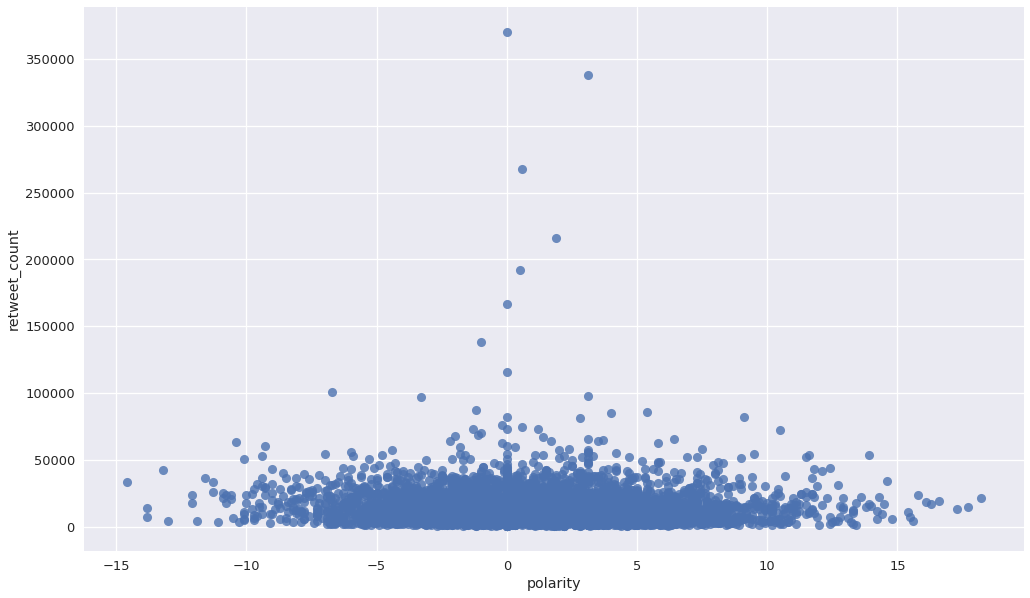

In [54]:
sentiment_length = trump
sentiment_length = sentiment_length.loc[:, ['retweet_count', 'polarity']]
plt.figure(figsize=(15, 10))
sns.regplot('polarity', 'retweet_count', data=sentiment_length, fit_reg=False)


### Discussion:

It seems that the tweets with the most retweets are the tweets that have polarity values near the neutral range, specifically around between -1 and +4 polarity values. This might be due to the different types of supporters; some are from the radical or extremist group while the others are from the typical conservative group. The extremists might tend to retweet more on the negative polarity tweets while the conservatives like tend to retweet more on the positive polarity tweets that include Trump's boasts on his accomplishments. Thus, the neutral-leaning polarity tweets have the most retweets since both spectrums of Trump's supporters as a whole tend to agree on the neutral-leaning polarity. 

## Submission

Congrats, you just finished Project 1!